# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>

## <span style="font-family: Arial, sans-serif; color:navyblue">CatBoost - Getting started</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>


In [1]:
import sys
from pathlib import Path

# Get the absolute path to the project root directory
ROOT_DIR = str(Path().absolute().parent)
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool

from xbooster.constructor import CatBoostScorecardConstructor

# Load and prepare the data
data_path = Path("__file__").parent / "data" / "test_data_01d9ab8b.csv"
credit_data = pd.read_csv(str(data_path))
num_features = ["Gross_Annual_Income", "Application_Score", "Bureau_Score"]
categorical_features = ["Time_with_Bank"]
features = num_features + categorical_features

# Prepare X and y
X = credit_data[features]
y = credit_data["Final_Decision"].replace({"Accept": 0, "Decline": 1})

# 2. Create CatBoost Pool
pool = Pool(
    data=X,
    label=y,
    cat_features=categorical_features,
)

# 3. Initialize and train CatBoost model
model = CatBoostClassifier(
    iterations=100,
    allow_writing_files=False,
    depth=3,
    learning_rate=0.1,
    verbose=0,
    one_hot_max_size=9999,  # Key for interpretability
)
model.fit(pool)

# 4. Create and fit the scorecard constructor
constructor = CatBoostScorecardConstructor(model, pool)

# 5. Construct the scorecard
scorecard = constructor.construct_scorecard()
print("\nScorecard:")
display(scorecard.head(3))

# Print raw leaf values
print("\nRaw Leaf Values:")
display(scorecard[["Tree", "LeafIndex", "XAddEvidence", "WOE"]].head(10))

# sc = constructor.create_points(pdo=50, target_points=600, target_odds=19, precision_points=0)

# Get raw scores (before creating points to avoid any interference)
raw_scores = constructor.predict_score(X, method="raw")
woe_scores = constructor.predict_score(X, method="woe")
points_scores = constructor.predict_score(X, method="pdo")

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_37082/4142729875.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = credit_data["Final_Decision"].replace({"Accept": 0, "Decline": 1})



Scorecard:


,Tree,LeafIndex,Feature,Sign,Split,CountPct,Count,NonEvents,Events,EventRate,XAddEvidence,WOE,IV,SHAP,DetailedSplit
0,0,0,Application_Score,<=,782.5,0.000362,45.0,11.0,34.0,0.755556,0.081,3.328374,2.182738,1.974891,Time_with_Bank != '402' AND Gross_Annual_Incom...
1,0,1,Application_Score,>,782.5,0.002373,295.0,270.0,25.0,0.084746,-0.160,-0.179637,0.002697,-0.021415,Time_with_Bank != '402' AND Gross_Annual_Incom...
2,0,2,Application_Score,<=,782.5,0.000523,65.0,22.0,43.0,0.661538,0.055,2.870067,1.612346,2.049738,Time_with_Bank != '402' AND Gross_Annual_Incom...



Raw Leaf Values:


,Tree,LeafIndex,XAddEvidence,WOE
0,0,0,0.081,3.328374
1,0,1,-0.160,-0.179637
2,0,2,0.055,2.870067
3,0,3,-0.187,-1.448892
4,0,4,0.000,0.000000
5,0,5,-0.025,1.101297
6,0,6,0.000,0.000000
7,0,7,-0.067,-4.706846
8,1,0,0.027,2.738906
9,1,1,0.000,0.000000


In [3]:
pd.DataFrame({"preds": model.predict_proba(X)[:, 1], "pdo": points_scores}).corr()

,preds,pdo
preds,1.00000,-0.91776
pdo,-0.91776,1.00000


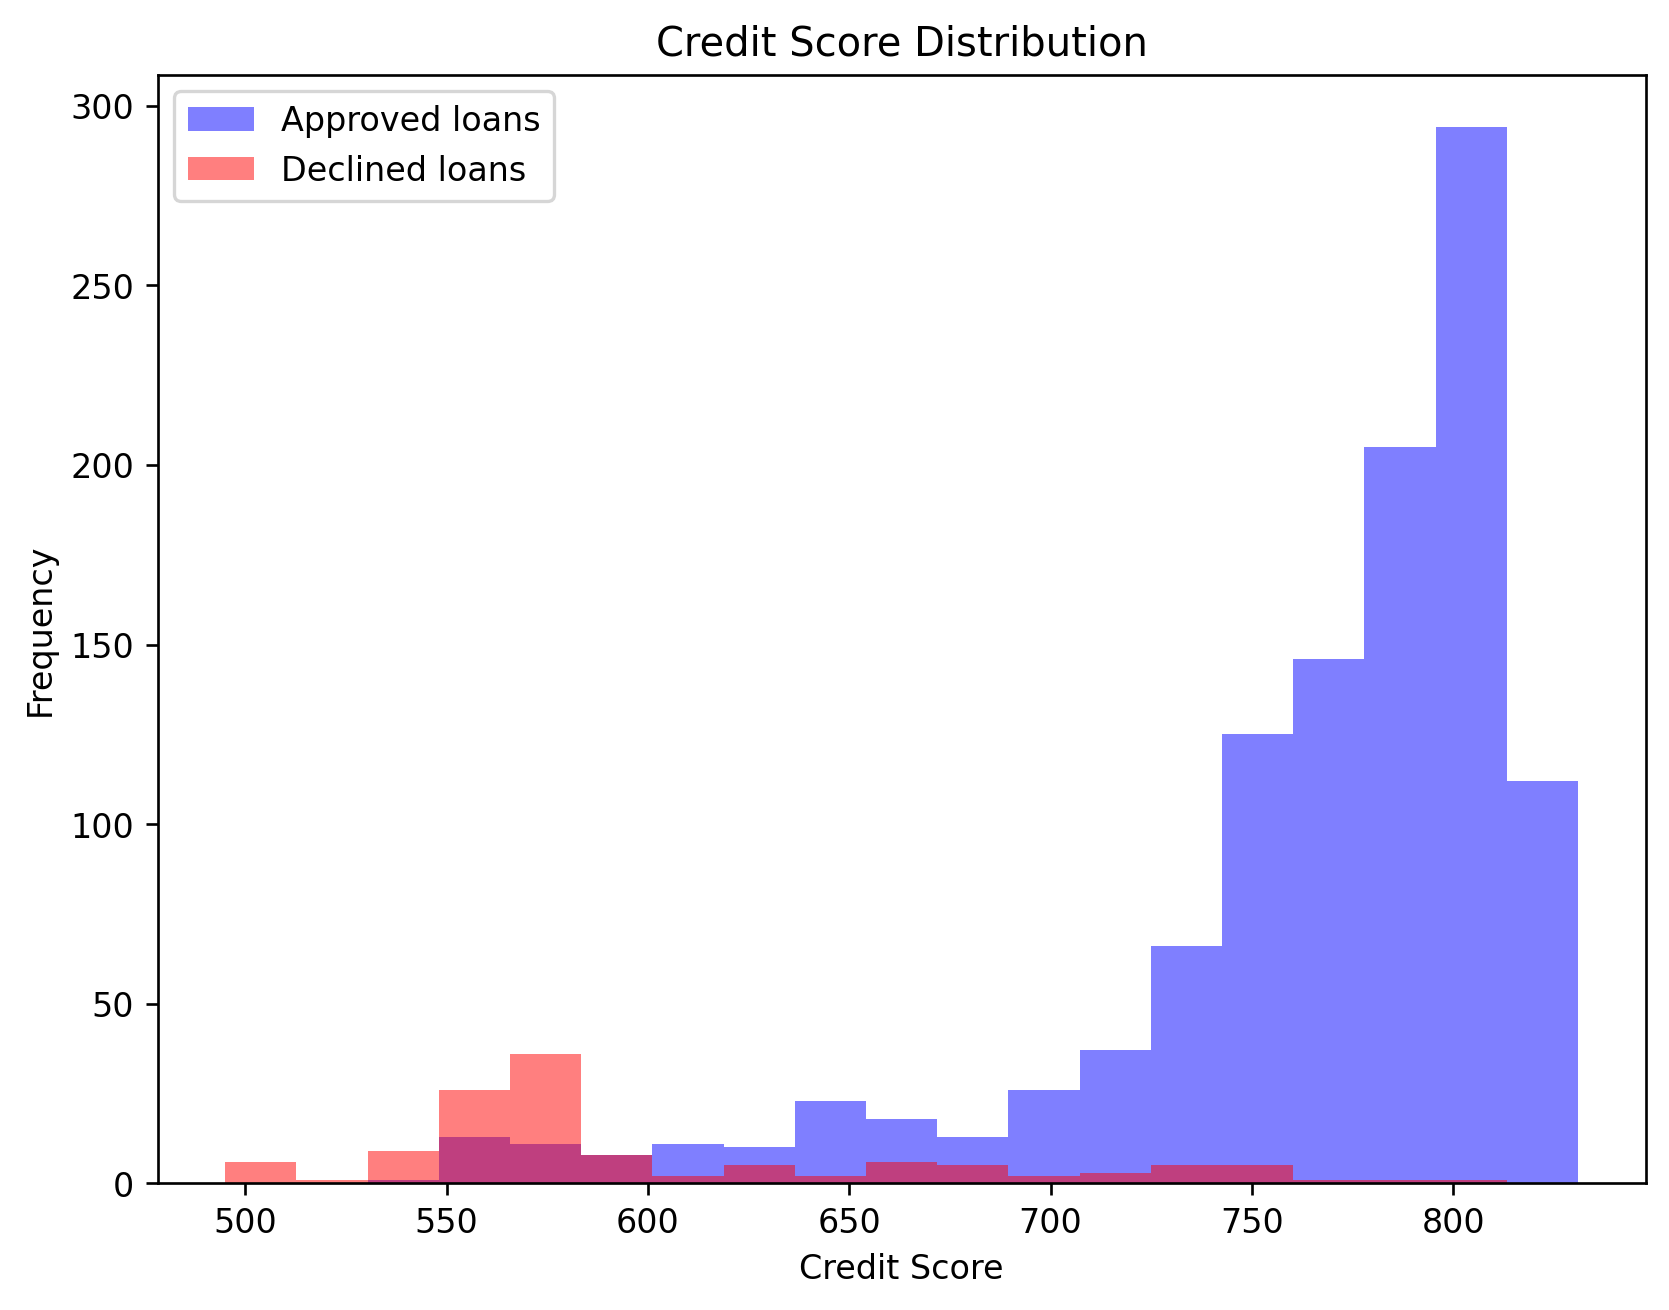

In [4]:
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(111)

# Create bins for the histogram
score_min, score_max = points_scores.min(), points_scores.max()
bins = np.linspace(score_min, score_max, 20)

# plot score hist based on y == 0
ax.hist(points_scores[y == 0], bins=bins, color="blue", alpha=0.5, label="Approved loans")
# plot score hist based on y == 1
ax.hist(points_scores[y == 1], bins=bins, color="red", alpha=0.5, label="Declined loans")
ax.set_xlabel("Credit Score")
ax.set_ylabel("Frequency")
ax.set_title("Credit Score Distribution")
ax.legend()
plt.show()

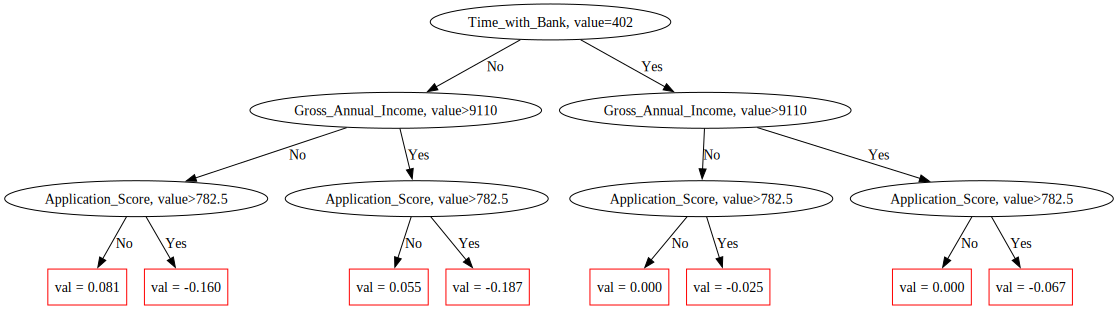

In [5]:
model.plot_tree(tree_idx=0, pool=pool)

### Compare performance of scores


In [6]:
from sklearn.metrics import roc_auc_score

# 6. Make predictions using different methods
raw_scores = constructor.predict_score(X, method="raw")
woe_scores = constructor.predict_score(X, method="woe")

# Original CatBoost predictions
cb_preds = model.predict(X, prediction_type="RawFormulaVal")
cb_gini = 2 * roc_auc_score(y, cb_preds) - 1
print("\nGini Coefficients:")
print(f"CatBoost: {cb_gini:.4f}")

# Raw scores
raw_gini = 2 * roc_auc_score(y, raw_scores) - 1
print(f"Raw Scores: {raw_gini:.4f}")

# WOE scores
woe_gini = 2 * roc_auc_score(y, woe_scores) - 1
print(f"WOE Scores: {woe_gini:.4f}")

# Points scores
points_scores = constructor.predict_score(X, method="pdo")
points_gini = 2 * roc_auc_score(y, points_scores) - 1
print(f"Points Scores: {points_gini:.4f}")

# 9. Get feature importance
feature_importance = constructor.get_feature_importance()
print("\nFeature Importance:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.4f}")

# Assert that raw scores match CatBoost predictions
np.testing.assert_allclose(raw_scores, cb_preds, rtol=1e-2, atol=1e-2)


Gini Coefficients:
CatBoost: 0.8958
Raw Scores: 0.8957
WOE Scores: 0.8957
Points Scores: -0.8936

Feature Importance:
Application_Score: 0.5113
Bureau_Score: 0.3472
Gross_Annual_Income: 0.1344
Time_with_Bank: 0.0072


### Plot feature importance


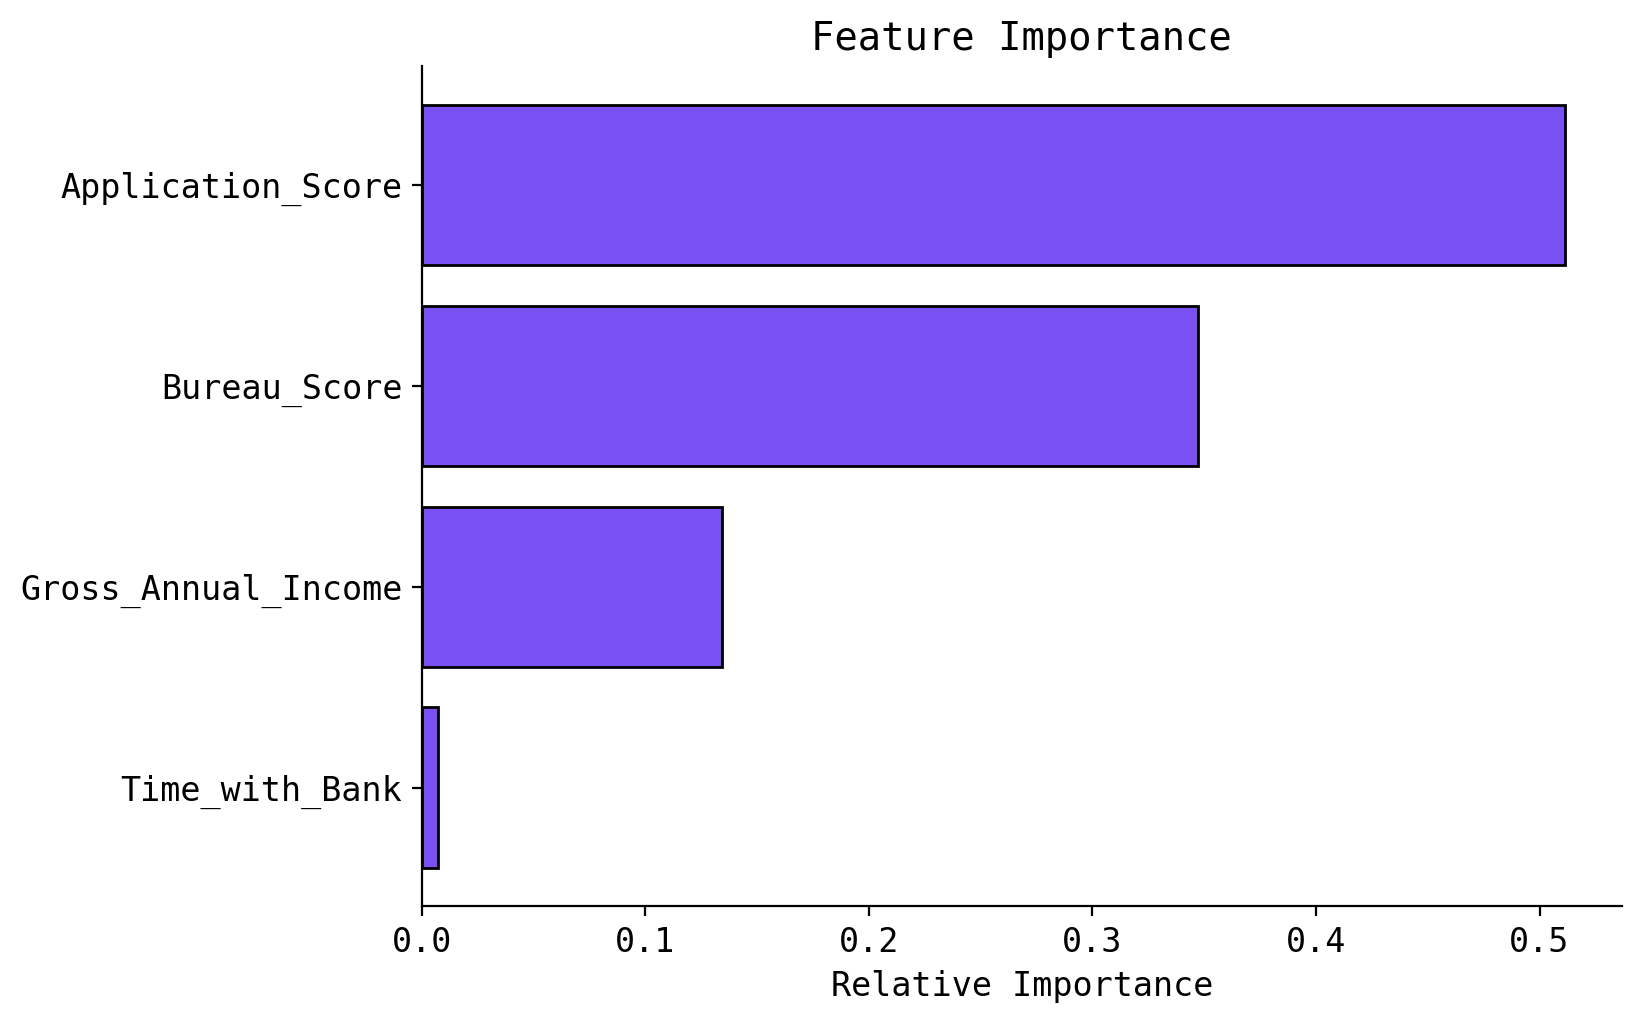

In [7]:
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Plot feature importance
constructor.plot_feature_importance()